In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from model_utils import train_torch_model, test_torch_model, port_mlp_to_ch, port_ch_to_mlp, proxy_train_mlp, get_CSMIA_case_by_case_results, CSMIA_attack
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from whitebox_attack import neuron_output, make_neuron_output_data, roc_curve_plot, get_LOMIA_case_1_correct_examples, Top10CorrNeurons, wb_corr_attacks
from disparate_vulnerability_utils import get_accuracy, get_indices_by_conditions, subgroup_vulnerability_distance_vector, subgroup_vulnerability_distance, get_subgroup_disparity, plot_subgroup_disparity, improved_subgroup_attack, get_subgroup_disparity_baseline, get_top_dist_indices, get_disparity_by_subgroup
import shap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [4]:
class MIAExperiment:
    def __init__(self, *args, **kwargs):
        self.sampling_condition_dict = kwargs.get('sampling_condition_dict', None)
        self.sensitive_column = kwargs.get('sensitive_column', 'MAR')

        for key, value in kwargs.items():
            setattr(self, key, value)

        if not hasattr(self, 'name'):
            self.name = 'Census19'
        self.ds = data_utils.CensusWrapper(
                    filter_prop="none", ratio=float(0.5), split="all", name=self.name, sampling_condition_dict=self.sampling_condition_dict, sensitive_column=self.sensitive_column,
                    additional_meta=None)
        (self.x_tr, self.y_tr), (self.x_te, self.y_te), self.cols = self.ds.load_data()
        self.X_train = pd.DataFrame(self.x_tr, columns=self.cols)
        self.X_test = pd.DataFrame(self.x_te, columns=self.cols)
        self.y_tr_onehot = self.ds.ds.y_enc.transform(self.y_tr).toarray()
        self.y_te_onehot = self.ds.ds.y_enc.transform(self.y_te).toarray()

    def __str__(self):
        return self.ds.ds.filenameroot
    
    def __repr__(self):
        return self.ds.ds.filenameroot
    
    def get_value_count_report(self):
        df = self.ds.ds.original_df
        df = df[df['is_train'] == 1]
        subgroup_values = df[self.subgroup_column].unique().tolist()
        for value in subgroup_values:
            print(f"Subgroup: {value}")
            # print(df[df[self.subgroup_column] == value].columns)
            # print(df[df[self.subgroup_column] == value][[self.sensitive_column, self.y_column]])
            new_df = df[df[self.subgroup_column] == value][[self.sensitive_column, self.y_column]]
            print(new_df.value_counts())
            # print(df[df[self.subgroup_column == value]][[self.sensitive_column, self.y_column]].corr())


    def get_mutual_information_between_sens_and_y(self):
        df = self.ds.ds.original_df
        df = df[df['is_train'] == 1]
        subgroup_values = df[self.subgroup_column].unique().tolist()
        mutual_info_dict = {}
        for value in subgroup_values:
            print(f"Subgroup: {value}")
            # All the features except y column
            X = df[df[self.subgroup_column] == value].drop([self.y_column], axis=1)
            y = df[df[self.subgroup_column] == value][[self.y_column]]
            # print(mutual_info_classif(X, y, discrete_features=True))
            mutual_info_dict[value] = mutual_info_classif(X, y, discrete_features=True)
        return mutual_info_dict

In [5]:
experiments = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict = 
    {
            'correlation': 0,
            'subgroup_col_name': 'SEX',
            'marginal_prior': 1,
            'corr_btn_sens_and_output_per_subgroup': (i, j),
            # 'fixed_corr_in_test_data': True
    }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})"
) for (i, j) in [(k, k) for k in [-0.4, -0.35, -0.3, -0.25, -0.2][:]]}
# ) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][3:4]}

{0: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}, 1: {(0, 1): 8750, (0, 0): 3750, (1, 1): 3750, (1, 0): 8750}}


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


{0: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}, 1: {(0, 1): 8437, (0, 0): 4062, (1, 1): 4063, (1, 0): 8438}}


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


{0: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}, 1: {(0, 1): 7812, (0, 0): 4687, (1, 1): 4688, (1, 0): 7813}}


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


{0: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


{0: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}, 1: {(0, 1): 8125, (0, 0): 4375, (1, 1): 4375, (1, 0): 8125}}


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


In [6]:
save_model = False

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf_only_on_test = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy_2.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        base_model = model_utils.get_model(max_iter=500)
        experiment.clf_only_on_test = copy.deepcopy(base_model)
        experiment.clf_only_on_test.fit(experiment.X_test, experiment.y_te_onehot)

        if save_model:
            model_utils.save_model(experiment.clf_only_on_test, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')

Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.35, -0.35RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.3, -0.3RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.25, -0.25RPAREN
Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.2, -0.2RPAREN


In [7]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(experiment.shortname)
    print(get_CSMIA_case_by_case_results(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds, 'SEX', metric='accuracy'))

Corr_btn_sens_and_output_for_male_(-0.4)_for_female_(-0.4)
                              1                0  Overall
Case 1           4610 (71.3449)   4197 (69.1446)  70.2964
Case 2          17704 (70.4417)  17666 (71.5385)  70.9895
Case 3           2686 (63.3656)   3137 (57.9216)  60.4328
Case All Cases   25000 (69.848)   25000 (69.428)  69.6380
Corr_btn_sens_and_output_for_male_(-0.35)_for_female_(-0.35)
                              1                0  Overall
Case 1           3723 (67.6873)   3107 (67.0743)  67.4085
Case 2          18380 (63.0631)  18320 (63.2806)  63.1717
Case 3           2897 (60.6835)   3573 (57.4867)  58.9181
Case All Cases   25000 (63.476)   25000 (62.924)  63.2000
Corr_btn_sens_and_output_for_male_(-0.3)_for_female_(-0.3)
                              1                0  Overall
Case 1           3376 (67.5355)   2854 (66.8886)  67.2392
Case 2          18454 (63.8507)  18302 (63.2554)  63.5542
Case 3           3170 (60.8517)   3844 (56.9459)  58.7111
Case All 

In [8]:
def inv_attack_training(experiment, df):
    X_attack, y_sens = experiment.ds.ds.get_attack_df(df)
    # Convert X to float
    X_attack = X_attack.astype(float)
    y_sens_onehot = experiment.ds.ds.sensitive_enc.transform(y_sens.to_numpy().ravel().reshape(-1, 1)).toarray()

    x_tr, x_te, y_tr, y_te = train_test_split(X_attack, y_sens_onehot, test_size=0.1, random_state=42)

    inv_clf = model_utils.get_model(max_iter=500)
    inv_clf.fit(x_tr, y_tr)
    # inv_clf = model_utils.proxy_train_mlp(x_tr.to_numpy(), y_tr, epochs=100)
    # inv_clfs[test_size] = inv_clf

    acc = 100 * inv_clf.score(x_te, y_te)
    print(f'Inverse accuracy with test size : {acc}')

    return inv_clf


In [9]:
def whitebox_neuron_attack(experiment):
    original_df_onehot = experiment.ds.ds.df.copy()

    original_df_onehot = original_df_onehot[original_df_onehot["is_train"]==0].drop("is_train", axis=1)

    X_attack_orig, y_sens_orig = experiment.ds.ds.get_attack_df(original_df_onehot)
    X_attack_orig = X_attack_orig.astype(float)

    x_tr, x_te, y_tr, y_te = train_test_split(X_attack_orig, y_sens_orig, test_size=0.9, random_state=42)
    clf = experiment.clf_only_on_test
    x_n_tr = make_neuron_output_data(experiment.ds, x_tr, clf, experiment.ds.ds.y_columns)
    x_n_te = make_neuron_output_data(experiment.ds, x_te, clf, experiment.ds.ds.y_columns)

    top_10_corr_neurons_model = wb_corr_attacks(x_n_tr, y_tr)

    result_dict = get_disparity_by_subgroup(attack_type='NEUR_IMP', ds=experiment.ds, subgroup_columns=['SEX'], X_att_query=X_attack_orig, y_att_query=y_sens_orig, metric='accuracy', clf=top_10_corr_neurons_model, df=X_attack_orig, MLP=clf)
    return result_dict

In [10]:
for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(experiment.shortname)
    print(whitebox_neuron_attack(experiment))

Corr_btn_sens_and_output_for_male_(-0.4)_for_female_(-0.4)
{'SEX': {0: 61.919999999999995, 1: 61.675999999999995, 'original': 61.797999999999995}}
Corr_btn_sens_and_output_for_male_(-0.35)_for_female_(-0.35)
{'SEX': {0: 62.148, 1: 60.868, 'original': 61.507999999999996}}
Corr_btn_sens_and_output_for_male_(-0.3)_for_female_(-0.3)
{'SEX': {0: 63.332, 1: 61.480000000000004, 'original': 62.40599999999999}}
Corr_btn_sens_and_output_for_male_(-0.25)_for_female_(-0.25)
{'SEX': {0: 61.980000000000004, 1: 59.275999999999996, 'original': 60.62800000000001}}
Corr_btn_sens_and_output_for_male_(-0.2)_for_female_(-0.2)
{'SEX': {0: 60.992000000000004, 1: 58.272, 'original': 59.632}}


In [95]:
original_df_onehot = experiment.ds.ds.df.copy()

original_df_onehot = original_df_onehot[original_df_onehot["is_train"]==0].drop("is_train", axis=1)

In [109]:
X_attack_orig, y_sens_orig = experiment.ds.ds.get_attack_df(original_df_onehot)
X_attack_orig = X_attack_orig.astype(float)

In [110]:
x_tr, x_te, y_tr, y_te = train_test_split(X_attack_orig, y_sens_orig, test_size=0.9, random_state=42)
clf = experiment.clf_only_on_test
x_n_tr = make_neuron_output_data(experiment.ds, x_tr, clf, experiment.ds.ds.y_columns)
x_n_te = make_neuron_output_data(experiment.ds, x_te, clf, experiment.ds.ds.y_columns)

top_10_corr_neurons_model = wb_corr_attacks(x_n_tr, y_tr)

In [118]:
get_disparity_by_subgroup(attack_type='NEUR_IMP', ds=experiment.ds, subgroup_columns=['SEX'], X_att_query=X_attack_orig, y_att_query=y_sens_orig, metric='accuracy', clf=top_10_corr_neurons_model, df=X_attack_orig, MLP=clf)

{'SEX': {0: 61.775999999999996, 1: 61.251999999999995, 'original': 61.514}}

In [97]:
aux_df_onehot = experiment.ds.ds.df.copy()

aux_df_onehot = aux_df_onehot[aux_df_onehot["is_train"]==1].drop("is_train", axis=1)

In [98]:
X_attack, y_sens = experiment.ds.ds.get_attack_df(aux_df_onehot)

In [103]:
experiment.inv_clf = inv_attack_training(experiment, aux_df_onehot)

Inverse accuracy with test size : 62.18


In [100]:
X_attack_orig, _ = experiment.ds.ds.get_attack_df(original_df_onehot)

In [104]:
sens_pred_inv_att = np.argmax(experiment.inv_clf.predict(X_attack_orig), axis=1)

In [105]:
np.mean(original_df_onehot['MAR_1'].to_numpy()==sens_pred_inv_att)

0.33966

In [44]:
def get_corr_btn_sens_and_out_for_indices(X, y, indices):
    X_new = X.loc[indices]
    y_new = y[indices]
    X_new = X_new[['MAR_1']].to_numpy().ravel()
    y_new = y_new.ravel()
    return np.corrcoef(X_new, y_new)[0, 1]

def get_percentage_of_same_sens_val_among_dist_k_neighbours(X, y, dist_matrix, index, k=3):
    dist_2_neighbours = dist_matrix[index] <= k
    orig_sens_val = X.iloc[index][f'{experiment.ds.ds.meta["sensitive_column"]}_1']
    return (X.iloc[dist_2_neighbours][f'{experiment.ds.ds.meta["sensitive_column"]}_1'] == orig_sens_val).mean()

# def find_neighbors_within_k_in_train(orig_df, aux_df, index, orig_sens_pred, k=4):
#     test_df = orig_df.copy()
#     test_df.loc[index, experiment.sensitive_column] = orig_sens_pred
#     # test_df = test_df.drop([experiment.sensitive_column], axis=1)
#     test_df = test_df.drop([experiment.y_column], axis=1)

#     train_df = aux_df.copy()
#     # train_df = train_df.drop([experiment.sensitive_column], axis=1)
#     train_df = train_df.drop([experiment.y_column], axis=1)

#     temp_np = train_df.to_numpy()[:50000, :]
#     temp_np = temp_np.astype(np.float32)
#     temp_np_1 = np.expand_dims(temp_np, 0)

#     temp_np = test_df.to_numpy()[index:index+1, :]
#     # temp_np[:, 3] = orig_sens_pred
#     temp_np = temp_np.astype(np.float32)
#     temp_np_2 = np.expand_dims(temp_np, 1)
    
#     dist_matrix = np.count_nonzero(temp_np_1 - temp_np_2, axis=2).ravel()
#     # print(dist_matrix)
    
#     return dist_matrix <= k

def find_neighbors_within_k_in_train(orig_df, aux_df, index, orig_sens_pred, k=4):
    train_df = orig_df.copy()
    # train_df.loc[index, experiment.sensitive_column] = orig_sens_pred
    train_df = train_df.drop([experiment.y_column], axis=1)

    # test_df = aux_df.copy()
    train_df = train_df.drop([experiment.sensitive_column], axis=1)
    # train_df = train_df.drop([experiment.y_column], axis=1)

    # aux_np = aux_df.drop([experiment.y_column], axis=1).to_numpy()
    aux_np = aux_df.drop([experiment.y_column, experiment.sensitive_column], axis=1).to_numpy()
    aux_np = aux_np.astype(np.float32)
    aux_np = np.expand_dims(aux_np, 0)

    temp_np = train_df.to_numpy()[index:index+1, :]
    # temp_np[:, 3] = orig_sens_pred
    temp_np = temp_np.astype(np.float32)
    temp_np_2 = np.expand_dims(temp_np, 1)
    
    dist_matrix = np.count_nonzero(aux_np - temp_np_2, axis=2).ravel()
    # print(dist_matrix)
    
    return dist_matrix <= k

def get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(X, y, orig_df, aux_df, orig_sens_pred, orig_y, index, k=4):
    dist_2_neighbours = find_neighbors_within_k_in_train(orig_df, aux_df, index, orig_sens_pred, k=k)
    # print(np.where(dist_2_neighbours)[0][:50])
    dist_2_neighbours_y_values = y[dist_2_neighbours].ravel().astype(np.float)
    dist_2_neighbours_w_same_y_indices = (orig_y == dist_2_neighbours_y_values)
    # print(dist_2_neighbours)
    # print(orig_sens_pred)
    # orig_sens_val = X.iloc[index][f'{experiment.ds.ds.meta["sensitive_column"]}_1']
    # return (X.iloc[dist_2_neighbours][f'{experiment.ds.ds.meta["sensitive_column"]}_1'] == orig_sens_pred).mean()
    return (X.iloc[dist_2_neighbours].iloc[dist_2_neighbours_w_same_y_indices][f'{experiment.ds.ds.meta["sensitive_column"]}_1'] == orig_sens_pred).mean()

# def get_percentage_of_same_sens_val_among_dist_k_neighbours(X, y, dist_matrix, index, k=3):
#     dist_2_neighbours = dist_matrix[index] <= k
#     X_temp = X.iloc[dist_2_neighbours]
#     orig_y = y[index]
#     dist_2_neighbours_y_values = y[dist_2_neighbours].ravel().astype(np.float)
#     # print(dist_2_neighbours_y_values)
#     dist_2_neighbours_w_same_y_indices = (orig_y == dist_2_neighbours_y_values)
#     orig_sens_val = X.iloc[index][f'{experiment.ds.ds.meta["sensitive_column"]}_1']
#     return (X_temp.iloc[dist_2_neighbours_w_same_y_indices][f'{experiment.ds.ds.meta["sensitive_column"]}_1'] == orig_sens_val).mean()

def get_percentage_of_same_y_among_dist_k_neighbours(X, y, dist_matrix, index, k=3):
    dist_2_neighbours = dist_matrix[index] <= k
    X_temp = X.iloc[dist_2_neighbours]
    orig_y = y[index]
    dist_2_neighbours_y_values = y[dist_2_neighbours].ravel().astype(np.float)
    return np.mean(dist_2_neighbours_y_values == orig_y)

def get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(X, y, sens_pred, case_indices, index, k=3):
    dist_2_neighbours = experiment.dist_matrix[index] <= k
    dominant_sens_val = np.sum(sens_pred[dist_2_neighbours] == 1) > np.sum(sens_pred[dist_2_neighbours] == 0)
    return np.mean(sens_pred[dist_2_neighbours] == dominant_sens_val)

def get_corr_btn_sens_and_out_among_dist_k_neighbours(X, y, dist_matrix, index, k=3):
    dist_2_neighbours = dist_matrix[index] <= k
    try:
        return get_corr_btn_sens_and_out_for_indices(X, y, dist_2_neighbours)
    except:
        return np.nan

In [48]:
index = case_2_correct_indices[2]

print(get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_random, experiment.y_random, original_df, experiment.X_random_df, sens_pred[index], experiment.y_te[index], index, k=5))

0.2559366754617414


In [49]:
index = case_2_incorrect_indices[1]

print(get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_random, experiment.y_random, original_df, experiment.X_random_df, sens_pred[index], experiment.y_te[index], index, k=5))

0.6962962962962963


In [50]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 1
k = 5
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_random, experiment.y_random, original_df, experiment.X_random_df, sens_pred[index], experiment.y_te[index], index, k=k) for index in case_1_correct_indices[:]])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours_in_aux_data(experiment.X_random, experiment.y_random, original_df, experiment.X_random_df, sens_pred[index], experiment.y_te[index], index, k=k) for index in case_1_incorrect_indices[:]])

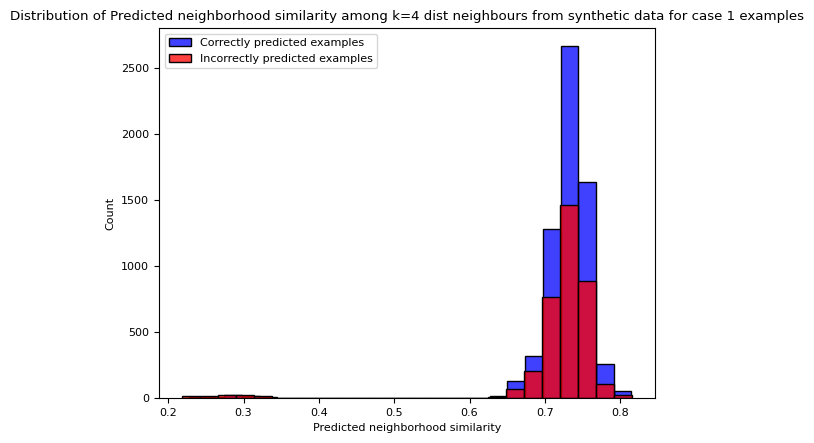

In [51]:
# sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
# sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
sns.histplot(perc_same_sens_val_correct, label='Correctly predicted examples', color='blue', element='bars', stat='count', bins=25)
sns.histplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples', color='red', element='bars', stat='count', bins=25)
plt.xlabel('Predicted neighborhood similarity')
plt.ylabel('Count')
plt.title('Distribution of Predicted neighborhood similarity among k=4 dist neighbours from synthetic data for case 1 examples')
plt.legend()
plt.show()

In [19]:
experiment.dist_matrix = experiment.dist_matrix.T

In [21]:
sens_pred_random, _ = CSMIA_attack(experiment.clf_only_on_test, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.ds.ds.meta)

In [42]:
index = case_2_correct_indices[100]
get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.y_te[index], sens_pred[index], sens_pred_random, case_indices, index, k=4)

0.28294117647058825

In [43]:
index = case_2_incorrect_indices[100]
get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.y_te[index], sens_pred[index], sens_pred_random, case_indices, index, k=4)

0.004201680672268907

In [32]:
case_2_correct_indices

array([    9,    16,    25, ..., 39208, 39243, 39244])

In [44]:
k = 4
perc_same_sens_val_pred_correct = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.y_te[index], sens_pred[index], sens_pred_random, case_indices, index, k=4) for index in case_2_correct_indices])
perc_same_sens_val_pred_incorrect = np.array([get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.y_te[index], sens_pred[index], sens_pred_random, case_indices, index, k=4) for index in case_2_incorrect_indices])

<Axes: ylabel='Density'>

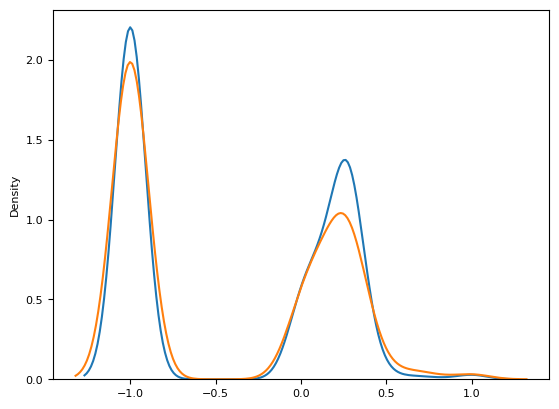

In [45]:
sns.kdeplot(perc_same_sens_val_pred_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_pred_incorrect, label='Incorrectly predicted examples')

In [96]:
for idx in range(1):
    index = case_2_correct_indices[idx+50]
    print(get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.dist_matrix, index, 4))

1.0


In [97]:
for idx in range(1):
    index = case_2_incorrect_indices[idx+2000]
    print(get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.dist_matrix, index, 4))

0.0


In [81]:
case_2_correct_indices

array([    9,    16,    25, ..., 39208, 39243, 39244])

In [ ]:
perc_same_sens_val_correct

In [ ]:
perc_same_sens_val_incorrect

In [106]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.dist_matrix, index, k) for index in case_2_correct_indices[-1000:]])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random.iloc[:50000], experiment.y_random[:50000], experiment.dist_matrix, index, k) for index in case_2_incorrect_indices[:1000]])

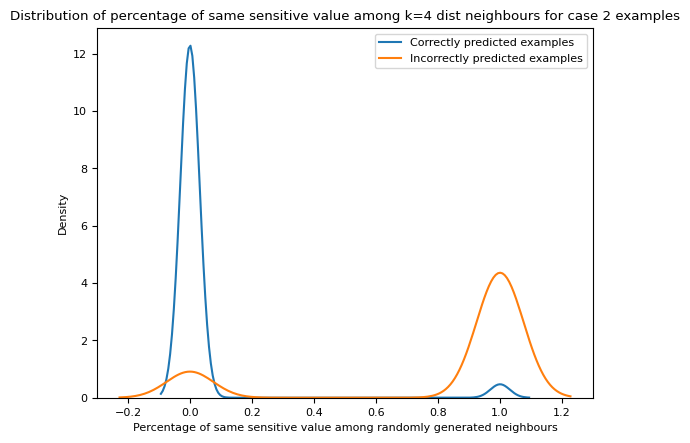

In [40]:
sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among randomly generated neighbours')
plt.ylabel('Density')
plt.title(f'Distribution of percentage of same sensitive value among k={k} dist neighbours for case 2 examples')
plt.legend()
plt.show()

In [107]:
from collections import Counter
Counter(np.nan_to_num(perc_same_sens_val_correct, nan=-1))

Counter({0.0: 774, -1.0: 226})

In [108]:
from collections import Counter
Counter(np.nan_to_num(perc_same_sens_val_incorrect, nan=-1))

Counter({1.0: 978, -1.0: 22})

In [9]:
experiment.X_random_df[['MAR', 'PINCP']].head(10)

,MAR,PINCP
5,0,0
6,1,1
7,0,0
8,0,0
9,1,0
12,1,1
14,0,0
16,1,0
18,0,0
23,0,0
